--------
## Step 1: Pseudocode
[Latex Source](https://www.overleaf.com/6663695rcdbbh#/22616031/)

--------
## Step 2: Simulations & Details of Their Parameters

##### Success
- A randomly generated 3 dimension data with outliers. Robust PCA will successfully reduce the dimension into 2 without taking into account the outlier (generated noise). 

##### Failure
- A randomly generated 3 dimension data with noise that isn't part of an extreme outlier. Robust PCA will fail to know which signal to take out.

-------
## Step 3: Choose Visualization
We will use a scatter plot in which the EEG data are shown- the pre- Robst PCA graph and the post- Robust PCA graph will be shown on the same plot. Correctly reduced PCA graphs will have less of a fluctuation. Also, we will use a graph to show in how much the outliers affect the final data.

-------
## Step 4: Specify Metrics for Evaluating Performance
We will use the mean squared error function. And we will manually set the threshold to 0.3. If the MCD method generates a robust covariance matrix that varies more than 0.3 with the original matrix, we call the performance invalid.

------
## Step 5: Write Code Generating Simulated Data

### Success
We first want to randomly generate two Gaussian set of samples as our data. And then we generate the outliers and add the outliers in at the end as part of the data.

We will generate n_samples = 20 per class x 2 classes for a total of 40. n_features = 3.

We will generate n_outliers = 5 per class x 2 classes for a total of 10.

% contamination is 20% outliers.

In [41]:
import numpy as np
import h5py
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(20)

# Mean is 0
mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

# Adding Outliers
outlier_array1 = np.array([[5,-5,6,4,7], [7,5,4,-7,5],[-6,4,7,4,-4]])
class1_sample_outliers = np.concatenate((class1_sample.T, outlier_array1.T))
class1_sample_outliers = class1_sample_outliers.T


# Mean is 1
mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3,20), "The matrix has not the dimensions 3x20"
outlier_array2 = np.array([[6,4,-5,-4,-7], [-4,6,-4,5,7],[4,-6,4,5,-6]])

# Adding Outliers
class2_sample_outliers = np.concatenate((class2_sample.T, outlier_array2.T))
class2_sample_outliers = class2_sample_outliers.T

### Failure

#### If we have structured noise, it's a lot harder for robust PCA to remove the noise because robust PCA does well with outliers.

In [155]:
structured_outliers1 = np.array([[1,1,1,1,1],[0,0,0,0,0],[1,1,1,1,1]])
structured_outliers2 = np.array([[-1,-1,-1,0,0],[1,1,1,-1,-1],[0,0,0,0,0]])
class1_sample_f = np.concatenate((class1_sample.T, structured_outliers1.T))
class1_sample_f = class1_sample_f.T
class2_sample_f = np.concatenate((class2_sample.T, structured_outliers2.T))
class2_sample_f = class2_sample_f.T

----------
## Step 7: Plot Simulated Data

Populating the interactive namespace from numpy and matplotlib


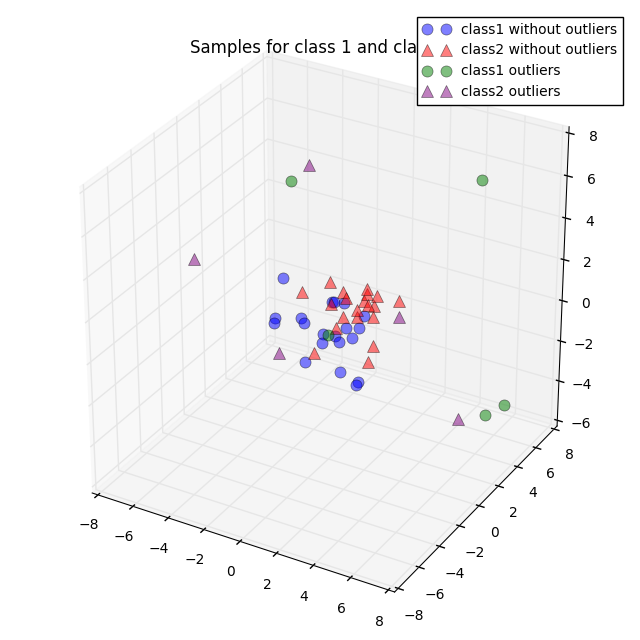

In [158]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1 without outliers')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2 without outliers')
ax.plot(outlier_array1[0,:], outlier_array1[1,:], outlier_array1[2,:], 'o', markersize=8, color='green', alpha=0.5, label='class1 outliers')
ax.plot(outlier_array2[0,:], outlier_array2[1,:], outlier_array2[2,:], '^', markersize=8, alpha=0.5, color='purple', label='class2 outliers')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

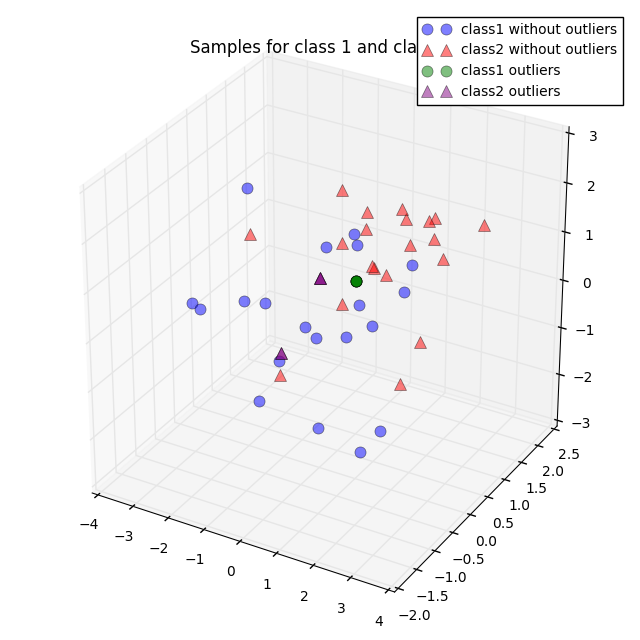

In [159]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1 without outliers')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2 without outliers')
ax.plot(structured_outliers1[0,:], structured_outliers1[1,:], structured_outliers1[2,:], 'o', markersize=8, color='green', alpha=0.5, label='class1 outliers')
ax.plot(structured_outliers2[0,:], structured_outliers2[1,:], structured_outliers2[2,:], '^', markersize=8, alpha=0.5, color='purple', label='class2 outliers')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

Note: The Purple curve is shown as the outlier or the "noise". 

---------
## Step 8: Write Algorithm Code

In [138]:
import sklearn

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy import stats
from sklearn.preprocessing import scale
from sklearn.covariance import EmpiricalCovariance, MinCovDet

all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])

print('Covariance Matrix:')
print(cov_mat)
all_samples_outliers= np.concatenate((class1_sample_outliers, class2_sample_outliers), axis = 1)
cov_mat_outliers = np.cov([all_samples_outliers[0,:],all_samples_outliers[1,:],all_samples_outliers[2,:]])
print('\n')

print('Covariance Matrix with Outliers:')
print(cov_mat_outliers)
print('\n')

mcd = MinCovDet().fit(all_samples_outliers.T)
print('Covariance Matrix with Outliers after Minimum Covariance Determinant:')
print(mcd.covariance_)

##Means
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_x_outliers = np.mean(all_samples_outliers[0,:])
mean_y_outliers = np.mean(all_samples_outliers[1,:])
mean_z_outliers = np.mean(all_samples_outliers[2,:])

mean_x_mcd = np.mean(mcd.covariance_[0,:])
mean_y_mcd = np.mean(mcd.covariance_[1,:])
mean_z_mcd = np.mean(mcd.covariance_[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])
mean_vector_outliers = np.array([[mean_x_outliers],[mean_y_outliers],[mean_z_outliers]])
mean_vector_mcd = np.array([[mean_x_mcd],[mean_y_mcd],[mean_z_mcd]])

Covariance Matrix:
[[ 1.93026494  0.2768482  -0.01951254]
 [ 0.2768482   1.02228574  0.28201249]
 [-0.01951254  0.28201249  1.15689301]]


Covariance Matrix with Outliers:
[[ 7.32981633 -0.27682989 -0.50949993]
 [-0.27682989  6.57297674 -2.63407303]
 [-0.50949993 -2.63407303  6.19533273]]


Covariance Matrix with Outliers after Minimum Covariance Determinant:
[[ 1.57425449  0.3519164   0.05922792]
 [ 0.3519164   1.0064569   0.26540931]
 [ 0.05922792  0.26540931  1.13947762]]


In [108]:
# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
eig_val_cov_outliers, eig_vec_cov_outliers = np.linalg.eig(cov_mat_outliers)
eig_val_cov_mcd, eig_vec_cov_mcd = np.linalg.eig(mcd.covariance_)

print('For Covariance Matrix without Outliers')
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('\n')
print('\n')
print('For Covariance Matrix Outliers')
for i in range(len(eig_val_cov_outliers)):
    eigvec_cov_outliers = eig_vec_cov_outliers[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov_outliers))
    print('Eigenvalue {} from covariance matrix with outliers: {}'.format(i+1, eig_val_cov_outliers[i]))
    print('\n')
print('\n')
print('For Covariance Matrix with Outliers and after MCD')
for i in range(len(eig_val_cov_mcd)):
    eigvec_cov_mcd = eig_vec_cov_mcd[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov_mcd))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov_mcd[i]))
    print('\n')

For Covariance Matrix without Outliers
Eigenvector 1: 
[[-0.95487254]
 [-0.28787211]
 [-0.07313053]]
Eigenvalue 1 from covariance matrix: 2.01223390092


Eigenvector 2: 
[[-0.19737917]
 [ 0.79900341]
 [-0.56800969]]
Eigenvalue 2 from covariance matrix: 0.753413437115


Eigenvector 3: 
[[-0.22194569]
 [ 0.52794242]
 [ 0.81976638]]
Eigenvalue 3 from covariance matrix: 1.34379635679




For Covariance Matrix Outliers
Eigenvector 1: 
[[-0.15130706]
 [-0.67052627]
 [-0.72629244]]
Eigenvalue 1 from covariance matrix with outliers: 3.65736593242


Eigenvector 2: 
[[-0.98462031]
 [ 0.16715941]
 [ 0.0507994 ]]
Eigenvalue 2 from covariance matrix with outliers: 7.40310043097


Eigenvector 3: 
[[-0.08734428]
 [-0.72280859]
 [ 0.68550618]]
Eigenvalue 3 from covariance matrix with outliers: 9.03765943711




For Covariance Matrix with Outliers and after MCD
Eigenvector 1: 
[[-0.84138412]
 [-0.46914842]
 [-0.26827696]]
Eigenvalue 1 from covariance matrix: 1.78936492996


Eigenvector 2: 
[[-0.4453267

In [110]:
print ('Covariance:')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs1 = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs1.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs1:
    print(i[0])

print('\n')
print('Outliers: ')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs2 = [(np.abs(eig_val_cov_outliers[i]), eig_vec_cov_outliers[:,i]) for i in range(len(eig_val_cov_outliers))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs2.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs2:
    print(i[0])

print('\n')
print('MCD: ')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs3 = [(np.abs(eig_val_cov_mcd[i]), eig_vec_cov_mcd[:,i]) for i in range(len(eig_val_cov_mcd))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs3.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs3:
    print(i[0])

Covariance:
2.01223390092
1.34379635679
0.753413437115


Outliers: 
9.03765943711
7.40310043097
3.65736593242


MCD: 
1.78936492996
1.20971171234
0.721112360517


In [116]:
matrix_w1 = np.hstack((eig_pairs1[0][1].reshape(3,1), eig_pairs1[1][1].reshape(3,1)))
print('Matrix W Cov')
print(matrix_w1)
print('\n')

matrix_w2 = np.hstack((eig_pairs2[0][1].reshape(3,1), eig_pairs2[1][1].reshape(3,1)))
print('Matrix W Outliers')
print(matrix_w2)
print('\n')
                      
matrix_w3 = np.hstack((eig_pairs3[0][1].reshape(3,1), eig_pairs3[1][1].reshape(3,1)))
print('Matrix W MCD')
print(matrix_w3)

Matrix W Cov
[[-0.95487254 -0.22194569]
 [-0.28787211  0.52794242]
 [-0.07313053  0.81976638]]


Matrix W Outliers
[[-0.08734428 -0.98462031]
 [-0.72280859  0.16715941]
 [ 0.68550618  0.0507994 ]]


Matrix W MCD
[[-0.84138412 -0.44532679]
 [-0.46914842  0.32060483]
 [-0.26827696  0.83600036]]


In [118]:
transformed1 = matrix_w1.T.dot(all_samples)
transformed2 = matrix_w2.T.dot(all_samples_outliers)
transformed3 = matrix_w3.T.dot(all_samples_outliers)

### Failure

In [160]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])

print('Covariance Matrix:')
print(cov_mat)
all_samples_f= np.concatenate((class1_sample_f, class2_sample_f), axis = 1)
cov_mat_f = np.cov([all_samples_f[0,:],all_samples_f[1,:],all_samples_f[2,:]])
print('\n')

print('Covariance Matrix with Structured Outliers:')
print(cov_mat_f)
print('\n')

mcdf = MinCovDet().fit(all_samples_f.T)
print('Covariance Matrix with Structured Outliers after Minimum Covariance Determinant:')
print(mcdf.covariance_)

##Means
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_x_f = np.mean(all_samples_f[0,:])
mean_y_f = np.mean(all_samples_f[1,:])
mean_z_f = np.mean(all_samples_f[2,:])

mean_x_mcdf = np.mean(mcdf.covariance_[0,:])
mean_y_mcdf = np.mean(mcdf.covariance_[1,:])
mean_z_mcdf = np.mean(mcdf.covariance_[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])
mean_vector_outliers = np.array([[mean_x_f],[mean_y_f],[mean_z_f]])
mean_vector_mcd = np.array([[mean_x_mcdf],[mean_y_mcdf],[mean_z_mcdf]])

Covariance Matrix:
[[ 1.93026494  0.2768482  -0.01951254]
 [ 0.2768482   1.02228574  0.28201249]
 [-0.01951254  0.28201249  1.15689301]]


Covariance Matrix with Outliers:
[[ 1.70512849  0.16659422  0.06700105]
 [ 0.16659422  0.9234013   0.21501307]
 [ 0.06700105  0.21501307  0.9718718 ]]


Covariance Matrix with Outliers after Minimum Covariance Determinant:
[[ 0.99839624  0.18620532  0.43507256]
 [ 0.18620532  0.84082127  0.09350006]
 [ 0.43507256  0.09350006  0.65961425]]


In [162]:
# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
eig_val_cov_f, eig_vec_cov_f = np.linalg.eig(cov_mat_f)
eig_val_cov_mcdf, eig_vec_cov_mcdf = np.linalg.eig(mcdf.covariance_)

print('For Covariance Matrix without Outliers')
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('\n')
print('\n')
print('For Covariance Matrix with Structured Outliers')
for i in range(len(eig_val_cov_f)):
    eigvec_cov_f = eig_vec_cov_f[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov_f))
    print('Eigenvalue {} from covariance matrix with outliers: {}'.format(i+1, eig_val_cov_f[i]))
    print('\n')
print('\n')
print('For Covariance Matrix with Outliers and after MCD')
for i in range(len(eig_val_cov_mcdf)):
    eigvec_cov_mcdf = eig_vec_cov_mcdf[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov_mcdf))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov_mcdf[i]))
    print('\n')

For Covariance Matrix without Outliers
Eigenvector 1: 
[[-0.95487254]
 [-0.28787211]
 [-0.07313053]]
Eigenvalue 1 from covariance matrix: 2.01223390092


Eigenvector 2: 
[[-0.19737917]
 [ 0.79900341]
 [-0.56800969]]
Eigenvalue 2 from covariance matrix: 0.753413437115


Eigenvector 3: 
[[-0.22194569]
 [ 0.52794242]
 [ 0.81976638]]
Eigenvalue 3 from covariance matrix: 1.34379635679




For Covariance Matrix with Structured Outliers
Eigenvector 1: 
[[ 0.96216639]
 [ 0.23033887]
 [ 0.14553295]]
Eigenvalue 1 from covariance matrix with outliers: 1.75514476834


Eigenvector 2: 
[[ 0.25854545]
 [-0.6033357 ]
 [-0.75441387]]
Eigenvalue 2 from covariance matrix with outliers: 1.12086461539


Eigenvector 3: 
[[ 0.08596561]
 [-0.76349855]
 [ 0.6400624 ]]
Eigenvalue 3 from covariance matrix with outliers: 0.724392204571




For Covariance Matrix with Outliers and after MCD
Eigenvector 1: 
[[-0.77551078]
 [-0.36055969]
 [-0.5182468 ]]
Eigenvalue 1 from covariance matrix: 1.37571285032


Eigenvector

In [164]:
print ('Covariance:')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs1 = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs1.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs1:
    print(i[0])

print('\n')
print('Structured Outliers: ')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs2f = [(np.abs(eig_val_cov_f[i]), eig_vec_cov_f[:,i]) for i in range(len(eig_val_cov_f))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs2f.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs2f:
    print(i[0])

print('\n')
print('MCD: ')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs3f = [(np.abs(eig_val_cov_mcdf[i]), eig_vec_cov_mcdf[:,i]) for i in range(len(eig_val_cov_mcdf))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs3f.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs3f:
    print(i[0])

Covariance:
2.01223390092
1.34379635679
0.753413437115


Structured Outliers: 
1.75514476834
1.12086461539
0.724392204571


MCD: 
1.37571285032
0.762790862467
0.360328050492


In [165]:
matrix_w1 = np.hstack((eig_pairs1[0][1].reshape(3,1), eig_pairs1[1][1].reshape(3,1)))
print('Matrix W Cov')
print(matrix_w1)
print('\n')

matrix_w2f = np.hstack((eig_pairs2f[0][1].reshape(3,1), eig_pairs2f[1][1].reshape(3,1)))
print('Matrix W Structured Outliers')
print(matrix_w2f)
print('\n')
                      
matrix_w3f = np.hstack((eig_pairs3f[0][1].reshape(3,1), eig_pairs3f[1][1].reshape(3,1)))
print('Matrix W MCD')
print(matrix_w3f)

Matrix W Cov
[[-0.95487254 -0.22194569]
 [-0.28787211  0.52794242]
 [-0.07313053  0.81976638]]


Matrix W Structured Outliers
[[ 0.96216639  0.25854545]
 [ 0.23033887 -0.6033357 ]
 [ 0.14553295 -0.75441387]]


Matrix W MCD
[[-0.77551078  0.26091612]
 [-0.36055969 -0.93053388]
 [-0.5182468   0.25696201]]


In [166]:
transformed1 = matrix_w1.T.dot(all_samples)
transformed2f = matrix_w2f.T.dot(all_samples_f)
transformed3f = matrix_w3f.T.dot(all_samples_f)

------
## Step 9: Write Qualitative Evaluation Code

### Success

Populating the interactive namespace from numpy and matplotlib


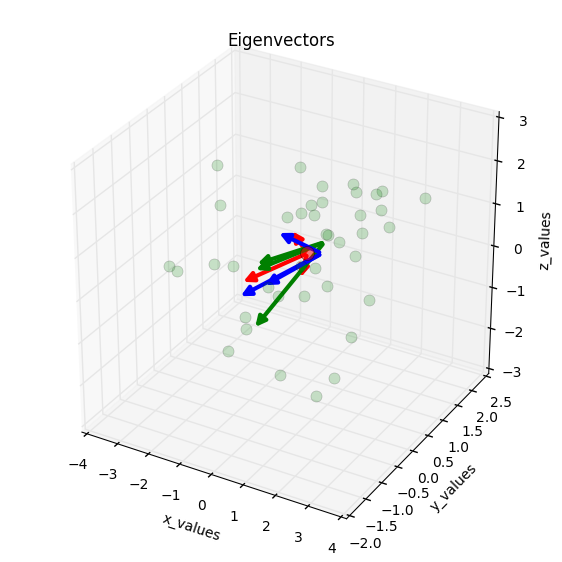

In [101]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_cov.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
for v in eig_vec_cov_outliers.T:
    a = Arrow3D([mean_x_outliers, v[0]], [mean_y_outliers, v[1]], [mean_z_outliers, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="g")
    ax.add_artist(a)
for v in eig_vec_cov_mcd.T:
    a = Arrow3D([mean_x_mcd, v[0]], [mean_y_mcd, v[1]], [mean_z_mcd, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="b")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

### Step 10: Qualitative Evaluation for Post-PCA Data

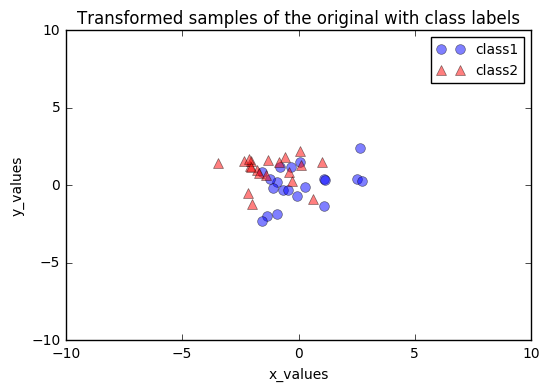

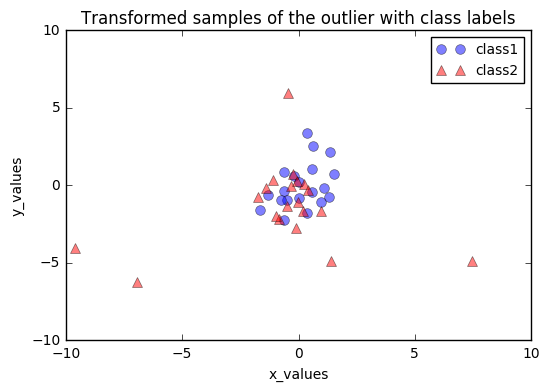

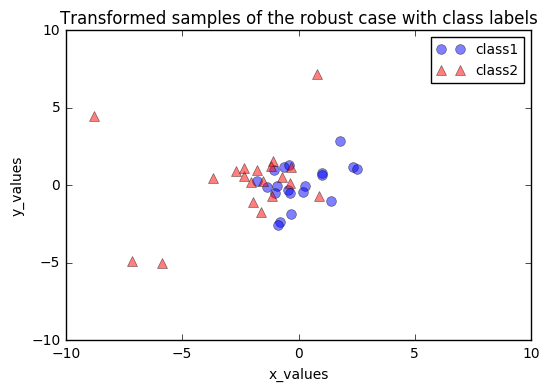

In [143]:
plt.plot(transformed1[0,0:20], transformed1[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed1[0,20:40], transformed1[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the original with class labels')

plt.show()

plt.plot(transformed2[0,0:20], transformed2[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed2[0,20:40], transformed2[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the outlier with class labels')

plt.show()

plt.plot(transformed3[0,0:20], transformed3[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed3[0,20:40], transformed3[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the robust case with class labels')

plt.show()

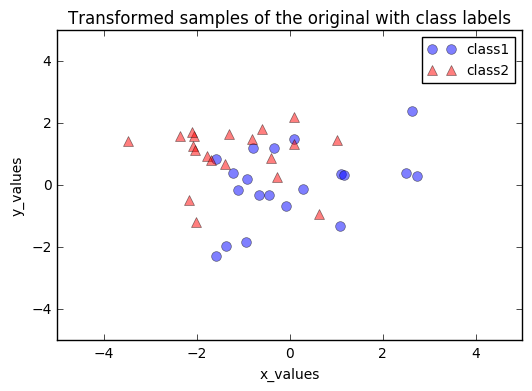

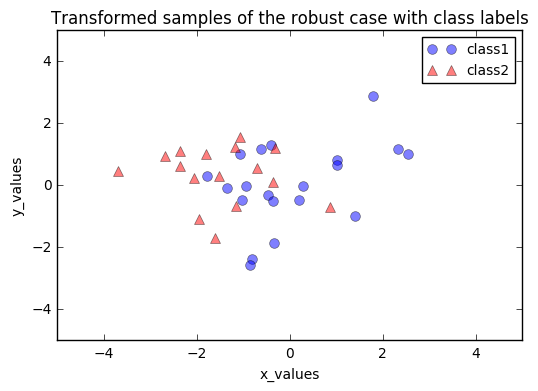

In [144]:
plt.plot(transformed1[0,0:20], transformed1[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed1[0,20:40], transformed1[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the original with class labels')

plt.show()

plt.plot(transformed3[0,0:20], transformed3[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed3[0,20:40], transformed3[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the robust case with class labels')

plt.show()

### Failure

Populating the interactive namespace from numpy and matplotlib


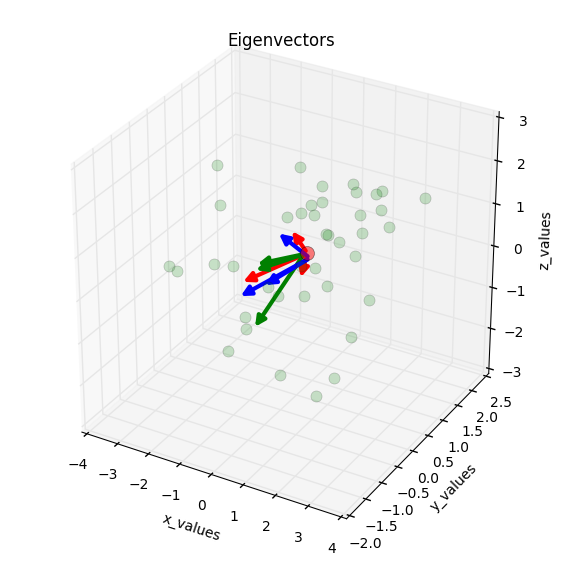

In [168]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_cov.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
for v in eig_vec_cov_outliers.T:
    a = Arrow3D([mean_x_f, v[0]], [mean_y_f, v[1]], [mean_z_f, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="g")
    ax.add_artist(a)
for v in eig_vec_cov_mcd.T:
    a = Arrow3D([mean_x_mcdf, v[0]], [mean_y_mcdf, v[1]], [mean_z_mcdf, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="b")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

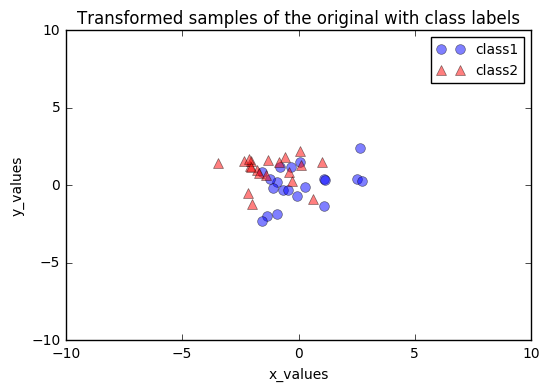

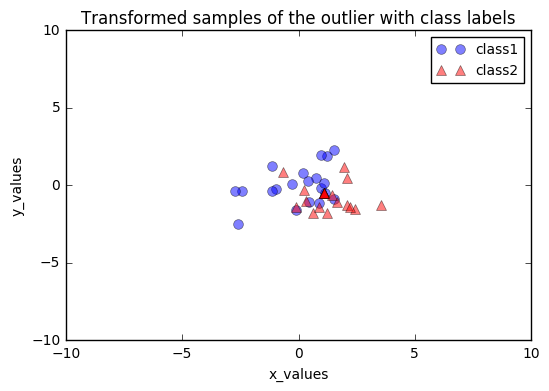

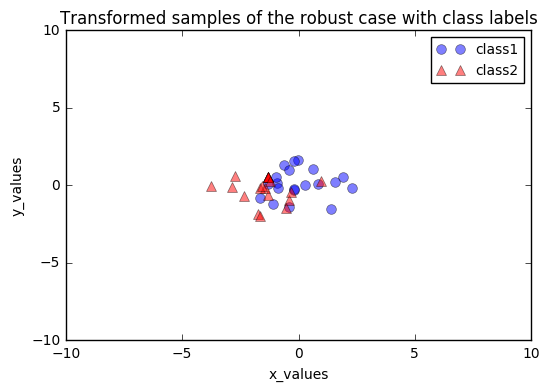

In [170]:
plt.plot(transformed1[0,0:20], transformed1[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed1[0,20:40], transformed1[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the original with class labels')

plt.show()

plt.plot(transformed2f[0,0:20], transformed2f[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed2f[0,20:40], transformed2f[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the outlier with class labels')

plt.show()

plt.plot(transformed3f[0,0:20], transformed3f[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed3f[0,20:40], transformed3f[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples of the robust case with class labels')

plt.show()

## Step 12: Quantitative Evaluation

For this, we can first use the error_norm function, which calculates the mean squared error between two covariance estimators.

In [152]:
print('Mean Squared Error between the post-MCD Covariance Matrix and the Original:')
print(mcd.error_norm(cov_mat))
print('\n')
print('Mean Squared Error between the post-MCD Covariance Matrix and the One with Outliers:')
print(mcd.error_norm(cov_mat_outliers))

Mean Squared Error between the post-MCD Covariance Matrix and the Original:
0.0505064050832


Mean Squared Error between the post-MCD Covariance Matrix and the One with Outliers:
35.9752827809


In [169]:
print('Mean Squared Error between the post-MCD Covariance Matrix and the Original:')
print(mcdf.error_norm(cov_mat))
print('\n')
print('Mean Squared Error between the post-MCD Covariance Matrix and the One with Outliers:')
print(mcdf.error_norm(cov_mat_outliers))

Mean Squared Error between the post-MCD Covariance Matrix and the Original:
0.549798715184


Mean Squared Error between the post-MCD Covariance Matrix and the One with Outliers:
40.2270710818


-------
## Step 13: Simulation Assessment
The algorithm performed as I anticipated on the simulated data, so it appears as though my understanding was good.